# Classification

In this notebook, we will train and test a classifier. We will test both logistic regression (LR) and random forests (RF).

## Generate a list of objects labelled by RGZ and Norris

Let's start by getting a list of all radio objects with both RGZ and Norris labels. For any given set of Franzen objects with the same ID, only the first component will be part of RGZ, so we will only look at first components. Norris et al. may have labelled the second (or third, etc.) component, so we need to associate each Norris label with the primary component.

The output of this section is a list of table keys for objects with a Norris and RGZ label.

In [3]:
import sklearn.model_selection, numpy, astropy.io.ascii as asc

In [4]:
table = asc.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')
# clean = numpy.array(asc.read('clean-atlas.tbl')['Clean']).astype(bool)
# clean.shape

In [5]:
primary_component_to_norris_swire = {}
primary_component_to_rgz_swire = {}
# Only includes primary components (though labels may come from any component).
primary_components_with_both_labels = set()
for row in table:# table[clean]
    primary_component_id = row['Primary Component ID (RGZ)']
    if not primary_component_id:
        # If something does not have a primary component ID, it cannot have an RGZ label, so we don't care about it!
        continue
    
    norris_swire = row['Source SWIRE (Norris)']
    rgz_swire = row['Source SWIRE Name (RGZ)']
    
    if not norris_swire or not rgz_swire or not norris_swire.startswith('SWIRE'):
        continue
    
    primary_component_to_norris_swire[primary_component_id] = norris_swire
    primary_component_to_rgz_swire[primary_component_id] = rgz_swire
    primary_components_with_both_labels.add(primary_component_id)

print(len(primary_components_with_both_labels))

keys = numpy.array([r['Key'] for r in table
        if r['Component Zooniverse ID (RGZ)'] and
        r['Component ID (Franzen)'] in primary_components_with_both_labels], dtype=int)
print(', '.join(table[keys]['Component Zooniverse ID (RGZ)']))

477
ARG0003rb2, ARG0003rfr, ARG0003r8s, ARG0003r2j, ARG0003raz, ARG0003ro4, ARG0003r8e, ARG0003r3w, ARG0003r55, ARG0003rj2, ARG0003rj6, ARG0003r8r, ARG0003r6i, ARG0003sky, ARG0003ref, ARG0003rbl, ARG0003r3k, ARG0003r88, ARG0003r38, ARG0003r29, ARG0003r93, ARG0003rbv, ARG0003r9h, ARG0003rgq, ARG0003r8u, ARG0003rbk, ARG0003rul, ARG0003rfd, ARG0003r3a, ARG0003rie, ARG0003r4g, ARG0003r7c, ARG0003r5o, ARG0003ra5, ARG0003rbe, ARG0003r2i, ARG0003r5p, ARG0003rdd, ARG0003r92, ARG0003r4w, ARG0003r7p, ARG0003r24, ARG0003r7n, ARG0003rcv, ARG0003raf, ARG0003r42, ARG0003ras, ARG0003rb7, ARG0003r4z, ARG0003r7w, ARG0003r9b, ARG0003r2a, ARG0003r17, ARG0003rea, ARG0003r3i, ARG0003r3q, ARG0003r4n, ARG0003r2f, ARG0003r5j, ARG0003ra1, ARG0003r6c, ARG0003r22, ARG0003rcf, ARG0003rfi, ARG0003r87, ARG0003r8b, ARG0003rbw, ARG0003r4m, ARG0003r5r, ARG0003r52, ARG0003r54, ARG0003r5x, ARG0003rfa, ARG0003r7j, ARG0003rdg, ARG0003r4r, ARG0003r8n, ARG0003r6v, ARG0003r3s, ARG0003r64, ARG0003r8z, ARG0003rce, ARG0003r6g, 

## Generate training/testing subsets

We want to use 5-fold cross-validation. We will do this cross-validation for the radio objects, not the IR objects we are actually classifying — this is to avoid overlapping image data; SWIRE objects associated with the same radio object break the independence assumption.

In [6]:
kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True)
# List of lists of one-table keys.
sets = [[keys[s] for s in f] for f in kf.split(keys)]

## Associate SWIRE objects with each set

These sets correspond to ATLAS objects; we want SWIRE objects to classify. We will convert each of these sets into sets of SWIRE indices.

In [8]:
import h5py
crowdastro_f = h5py.File('/Users/alger/data/Crowdastro/crowdastro-swire.h5', 'r')

In [9]:
import scipy.spatial
swire_coords = crowdastro_f['/swire/cdfs/numeric'][:, :2]
swire_tree = scipy.spatial.KDTree(swire_coords)
swire_names = crowdastro_f['/swire/cdfs/string'].value
name_to_crowdastro = {j.decode('ascii'):i for i, j in enumerate(swire_names)}

In [10]:
swire_sets = []
norris_label_sets = []
rgz_label_sets = []
for split in sets:
    swire_split = []
    for ts in split:
        # ts is a list of keys.
        locs = numpy.array([(i[0], i[1]) for i in table['Component RA (Franzen)', 'Component DEC (Franzen)'][ts]])
        nearby_swire_indices = sorted(set(numpy.concatenate(swire_tree.query_ball_point(locs, 1 / 60))))  # 1 arcmin
        swire_split.append(nearby_swire_indices)

    swire_sets.append(swire_split)

## Generate Features for Each SWIRE Object

For each SWIRE object in crowdastro $\cap$ the training/testing sets, we need the distance to the closest radio object, the stellarity, the band 1 - 2 and band 2 - 3 magnitude differences, and an image. The distances and images are generated by `crowdastro generate_training_data`; the magnitude differences and stellarity can be pulled from the SWIRE catalogue available [here](http://swire.ipac.caltech.edu/swire/astronomers/data/SWIRE3_CDFS_cat_IRAC24_21Dec05.tbl.gz).

In [14]:
training_f = h5py.File('/Users/alger/data/Crowdastro/training-swire.h5', 'r')
swire_distances = training_f['raw_features'][:, 8]
swire_images = training_f['raw_features'][:, 9:]
assert swire_images.shape[1] == 32 * 32

In [31]:
# AstroPy can't deal with a large file like the SWIRE file, so we have to do this line-by-line...
SPITZER_SENSITIVITIES = {
    36: 7.3,
    45: 9.7,
    58: 27.5,
    80: 32.5,
    24: 450,
}
headers = []
swire_features = numpy.zeros((len(swire_coords),
                              6 +  # Magnitude differences
                              1 +  # S_3.6
                              2 +  # Stellarities
                              1 +  # Distances
                              32 * 32  # Image
                             ))
for row_num, line in enumerate(open('/Users/alger/data/SWIRE/SWIRE3_CDFS_cat_IRAC24_21Dec05.tbl')):
    if line.startswith('\\'):
        continue
    
    if line.startswith('|') and not headers:
        headers.extend(map(str.strip, line.split('|')[1:-1]))
        lengths = list(map(len, headers))
        continue
    
    if line.startswith('|'):
        continue
    
    line = dict(zip(headers, line.split()))
    
    name = line['object']
    if name not in name_to_crowdastro:
        continue  # Skip non-crowdastro SWIRE.

    crowdastro_index = name_to_crowdastro[name]

    fluxes = []
    for s in [36, 45, 58, 80]:
        aps = []
        for ap in range(1, 6):
            v = line['flux_ap{}_{}'.format(ap, s)]
            try:
                v = float(v)
                if v != -99.0:
                    aps.append(v)
            except:
                pass
        
        if aps:
            fluxes.append(numpy.mean(aps))
        else:
            fluxes.append(SPITZER_SENSITIVITIES[s])  # 5 sigma is an upper-bound for flux in each band.
    mags = [numpy.log10(s) for s in fluxes]
    mag_diffs = [mags[0] - mags[1], mags[0] - mags[2], mags[0] - mags[3],
                 mags[1] - mags[2], mags[1] - mags[3],
                 mags[2] - mags[3]]
    # Guaranteed a stellarity in the first two bands; not so much in the others.
    stellarities_ = [line['stell_{}'.format(s)] for s in [36, 45]]
    stellarities = []
    for s in stellarities_:
        if s != 'null' and s != '-9.00':
            stellarities.append(float(s))
        else:
            stellarities.append(float('nan'))
    # We will have nan stellarities - but we will replace those with the mean later.
    features = numpy.concatenate([
        mag_diffs,
        mags[:1],
        stellarities,
        [swire_distances[crowdastro_index]],
        swire_images[crowdastro_index],
    ])
    swire_features[crowdastro_index] = features

In [32]:
# Set nans to the mean.
for feature in range(swire_features.shape[1]):
    nan = numpy.isnan(swire_features[:, feature])
    swire_features[:, feature][nan] = swire_features[:, feature][~nan].mean()

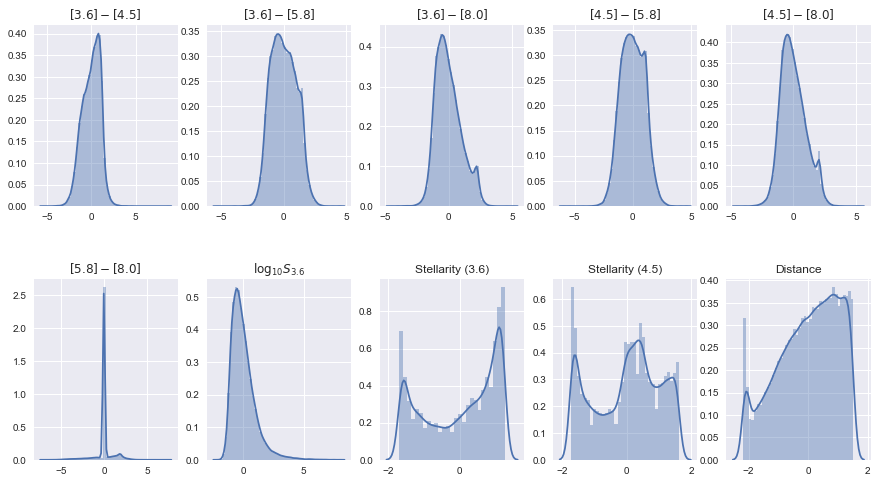

In [37]:
import seaborn, matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
feature_names = ['$[3.6] - [4.5]$', '$[3.6] - [5.8]$', '$[3.6] - [8.0]$',
                 '$[4.5] - [5.8]$', '$[4.5] - [8.0]$',
                 '$[5.8] - [8.0]$', '$\log_{10} S_{3.6}$',
                 'Stellarity (3.6)', 'Stellarity (4.5)', 'Distance']
for feature in range(10):
    plt.subplot(2, 5, feature + 1)
    plt.title(feature_names[feature])
    seaborn.distplot(swire_features[:, feature])
plt.subplots_adjust(hspace=0.4)
plt.show()

In [34]:
# Normalise and centre the features.
swire_features -= swire_features.mean(axis=0)
swire_features /= swire_features.std(axis=0)

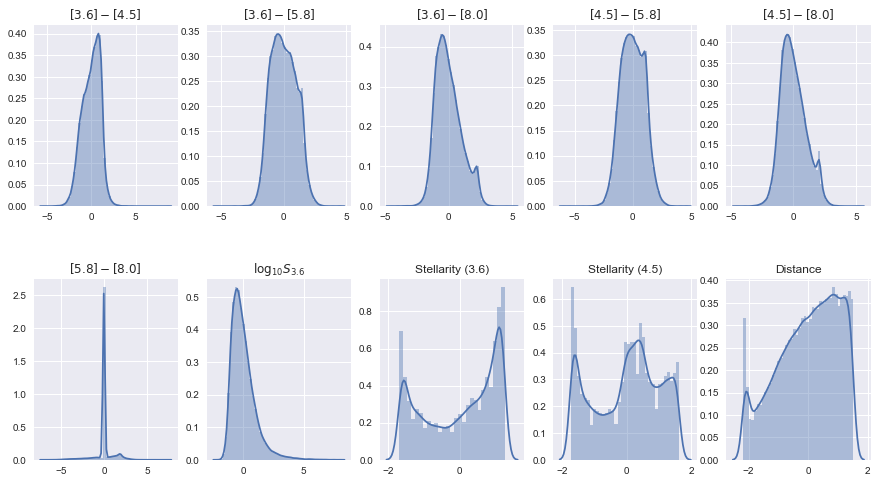

In [40]:
plt.figure(figsize=(15, 8))
feature_names = ['$[3.6] - [4.5]$', '$[3.6] - [5.8]$', '$[3.6] - [8.0]$',
                 '$[4.5] - [5.8]$', '$[4.5] - [8.0]$',
                 '$[5.8] - [8.0]$', '$\log_{10} S_{3.6}$',
                 'Stellarity (3.6)', 'Stellarity (4.5)', 'Distance']
for feature in range(10):
    plt.subplot(2, 5, feature + 1)
    plt.title(feature_names[feature])
    seaborn.distplot(swire_features[:, feature])
plt.subplots_adjust(hspace=0.4)
plt.show()

## Generate labels for each SWIRE object

In [41]:
swire_norris_labels = numpy.zeros((len(swire_coords),), dtype=bool)
swire_rgz_labels = numpy.zeros((len(swire_coords),), dtype=bool)

In [42]:
import astropy.coordinates, re
for row in table:
    n = row['Source SWIRE (Norris)']
    if n and n.startswith('SWIRE'):
        if n in name_to_crowdastro:
            index = name_to_crowdastro[n]
            swire_norris_labels[index] = True
        else:
            m = re.match(r'SWIRE3_J(\d\d)(\d\d)(\d\d\.\d\d)(-\d\d)(\d\d)(\d\d\.\d)', n)
            ra, dec = ' '.join(m.groups()[:3]), ' '.join(m.groups()[3:])
            sc = astropy.coordinates.SkyCoord(ra=ra, dec=dec, unit=('hourangle', 'deg'))
            coord = (sc.ra.deg, sc.dec.deg)
            dist, index = swire_tree.query(coord)
            if dist < 5 / 60 / 60:
                swire_norris_labels[index] = True
    
    n = row['Source SWIRE Name (RGZ)']
    if n:
        index = name_to_crowdastro[n]
        swire_rgz_labels[index] = True

In [43]:
swire_norris_labels.sum(), swire_rgz_labels.sum()

(507, 2211)

## Experiment: Logistic regression

In this section, we will run logistic regression trained on RGZ/Norris and tested on RGZ/Norris.

In [44]:
import sklearn.linear_model, crowdastro.crowd.util, itertools
bas = {'RGZ': {'RGZ': [], 'Norris': []}, 'Norris': {'RGZ': [], 'Norris': []}}
for (train_name, train_labels), (test_name, test_labels) in itertools.product(
        [('RGZ', swire_rgz_labels), ('Norris', swire_norris_labels)], repeat=2):
    for train, test in swire_sets:
        X_train = swire_features[train, :]
        X_test = swire_features[test, :]
        T_train = train_labels[train]
        T_test = test_labels[test]
        lr = sklearn.linear_model.LogisticRegression(class_weight='balanced', penalty='l1')
        lr.fit(X_train, T_train)
        preds = lr.predict(X_test)
        ba = crowdastro.crowd.util.balanced_accuracy(T_test, preds)
        bas[train_name][test_name].append(ba)

In [45]:
for tr in ['RGZ', 'Norris']:
    for te in ['RGZ', 'Norris']:
        print('LR({:^6}) vs {:^6}: ({:.02f} +- {:.02f})%'.format(
            tr, te,
            numpy.mean(bas[tr][te]) * 100,
            numpy.std(bas[tr][te]) * 100))

LR( RGZ  ) vs  RGZ  : (93.34 +- 1.74)%
LR( RGZ  ) vs Norris: (94.14 +- 1.50)%
LR(Norris) vs  RGZ  : (93.92 +- 1.33)%
LR(Norris) vs Norris: (96.13 +- 1.63)%


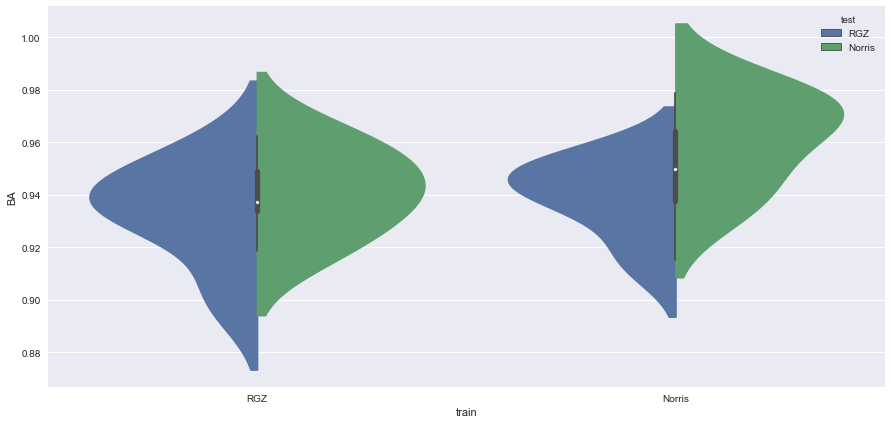

In [46]:
import astropy.table
def plot_bas(bas):
    dx = []
    dy = []
    dh = []
    for train in bas:
        for test in bas[train]:
            for i in bas[train][test]:
                dx.append(train)
                dh.append(test)
                dy.append(i)
    data = astropy.table.Table(data=[dx, dy, dh], names=('train', 'BA', 'test')).to_pandas()
    ax = plt.figure(figsize=(15, 7))
    vp = seaborn.violinplot(
        scale='width',
        orient='v',
        x='train',
        y='BA',
        hue='test',
        data=data,
        split=True)
    plt.show()

plot_bas(bas)

## Experiment: Random forests

Same as above, with random forests.

In [52]:
import sklearn.ensemble
bas_rf = {'RGZ': {'RGZ': [], 'Norris': []}, 'Norris': {'RGZ': [], 'Norris': []}}
for (train_name, train_labels), (test_name, test_labels) in itertools.product(
        [('RGZ', swire_rgz_labels), ('Norris', swire_norris_labels)], repeat=2):
    for train, test in swire_sets:
        X_train = swire_features[train, :]
        X_test = swire_features[test, :]
        T_train = train_labels[train]
        T_test = test_labels[test]
        rf = sklearn.ensemble.RandomForestClassifier(class_weight='balanced', criterion='entropy',
                                                     min_samples_leaf=40)
        rf.fit(X_train, T_train)
        preds = rf.predict(X_test)
        ba = crowdastro.crowd.util.balanced_accuracy(T_test, preds)
        bas_rf[train_name][test_name].append(ba)

In [53]:
for tr in ['RGZ', 'Norris']:
    for te in ['RGZ', 'Norris']:
        print('RF({:^6}) vs {:^6}: ({:.02f} +- {:.02f})%'.format(
            tr, te,
            numpy.mean(bas_rf[tr][te]) * 100,
            numpy.std(bas_rf[tr][te]) * 100))

RF( RGZ  ) vs  RGZ  : (94.24 +- 1.50)%
RF( RGZ  ) vs Norris: (96.46 +- 0.67)%
RF(Norris) vs  RGZ  : (89.42 +- 2.09)%
RF(Norris) vs Norris: (96.92 +- 0.92)%


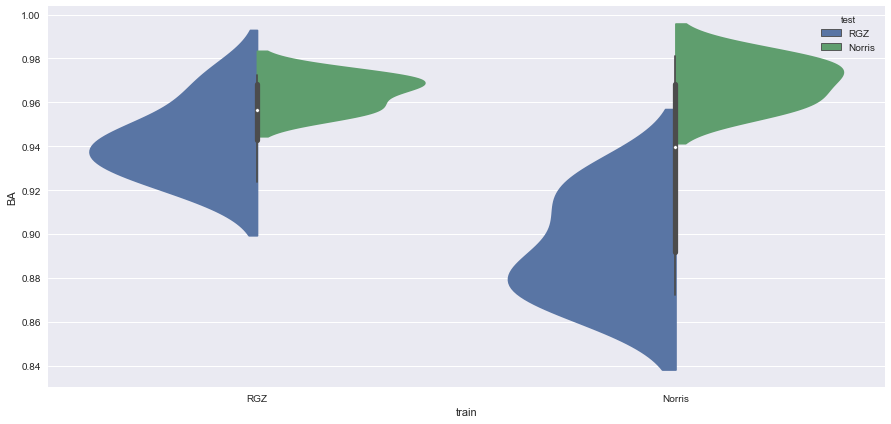

In [54]:
plot_bas(bas_rf)

## Experiment: Feature ablation

We will now repeat this experiment with different subsets of features to determine which features are most useful in making our predictions.

In particular, we expect distance to be the most important predictor by far &mdash; for compact objects, the centre of the Gaussian fit to the radio object will most likely be the location of the host galaxy.

We will use Norris labels for both training and testing.

We will test subsets where we remove:
- Distance
- Magnitude differences
- Stellarity
- Image
- All combinations thereof.

In [55]:
def powerset(iterable: [1,2,3]) -> [(), (1,), (2,), (3,), (1,2), (1,3), (2,3), (1,2,3)]:
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

In [56]:
featuresets = {
    'colour': swire_features[:, :2],
    'stellarity': swire_features[:, 2:4],
    'distance': swire_features[:, 4:5],
    'image': swire_features[:, 5:],
}

import collections
bas_ablation = collections.defaultdict(list)  # Maps features -> balanced accuracies.

for i in powerset(['distance', 'colour', 'stellarity', 'image']):
    if not i:
        continue
    
    print('Testing features:', ', '.join(i))
    for train, test in swire_sets:
        this_featureset = numpy.concatenate([featuresets[j] for j in i], axis=1)
        X_train = this_featureset[train, :]
        X_test = this_featureset[test, :]
        T_train = swire_norris_labels[train]
        T_test = swire_norris_labels[test]
        lr = sklearn.linear_model.LogisticRegression(class_weight='balanced', penalty='l1')
        lr.fit(X_train, T_train)
        preds = lr.predict(X_test)
        ba = crowdastro.crowd.util.balanced_accuracy(T_test, preds)
        bas_ablation[i].append(ba)

Testing features: distance
Testing features: colour
Testing features: stellarity
Testing features: image


KeyboardInterrupt: 

In [ ]:
# for i in powerset(['distance', 'colour', 'stellarity', 'image']):
#     if not i:
#         continue

#     print('{:<40}: ({:.02f} +- {:.02f})%'.format(
#         ', '.join(i),
#         numpy.mean(bas_ablation[i]) * 100,
#         numpy.std(bas_ablation[i]) * 100))
ax = plt.figure(figsize=(15, 7))
vp = seaborn.violinplot(
    scale='width',
    orient='v',
    data=[bas_ablation[i] for i in sorted(bas_ablation.keys())])
vp.set_xticklabels(sorted([', '.join(k) for k in bas_ablation.keys()]), rotation='vertical')
plt.show()

## Export

We will now export our sets, labels, and features.

In [58]:
import h5py

# Convert SWIRE/ATLAS sets into boolean arrays.
n_swire = len(swire_coords)
n_atlas = crowdastro_f['/atlas/cdfs/numeric'].shape[0]
swire_sets_train_bool = numpy.zeros((5, n_swire), dtype=bool)
swire_sets_test_bool = numpy.zeros((5, n_swire), dtype=bool)
for k in range(5):
    swire_sets_train_bool[k, swire_sets[k][0]] = True
    swire_sets_test_bool[k, swire_sets[k][1]] = True

with h5py.File('/Users/alger/data/Crowdastro/swire_11_05_17.h5', 'w') as f:
    f.create_dataset('features', data=swire_features)
    f.create_dataset('rgz_labels', data=swire_rgz_labels)
    f.create_dataset('norris_labels', data=swire_norris_labels)
    f.create_dataset('clean_swire_sets_train', data=swire_sets_train_bool)
    f.create_dataset('clean_swire_sets_test', data=swire_sets_test_bool)